In [1]:
import jax
from jax import config
config.update("jax_enable_x64", True)
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import sax
import pandas as pd
import simphony
from simphony.quantum import QuantumTimeElement
from simphony.libraries import siepic, ideal
from simphony.utils import smooth_rectangular_pulse, dict_to_matrix, gaussian_pulse
from simphony.time_domain.baseband_vector_fitting import BasebandModel
from scipy import signal
from scipy.signal import  StateSpace, dlsim


In [2]:
def dlsim_complex(system, u, t=None, x0=None):
    out_samples = len(u)
    stoptime = (out_samples - 1) * system.dt

    xout = np.zeros((out_samples, system.A.shape[0]), dtype=complex)
    yout = np.zeros((out_samples, system.C.shape[0]), dtype=complex)
    tout = np.linspace(0.0, stoptime, num=out_samples)

    xout[0, :] = np.zeros((system.A.shape[1],), dtype=complex)

    u_dt = u

    # Simulate the system
    for i in range(0, out_samples - 1):
        xout[i+1, :] = (np.dot(system.A, xout[i, :]) +
                        np.dot(system.B, u_dt[i, :]))
        yout[i, :] = (np.dot(system.C, xout[i, :]) +
                    np.dot(system.D, u_dt[i, :]))

    # Last point
    yout[out_samples-1, :] = (np.dot(system.C, xout[out_samples-1, :]) +
                            np.dot(system.D, u_dt[out_samples-1, :]))

    return tout, yout, xout

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


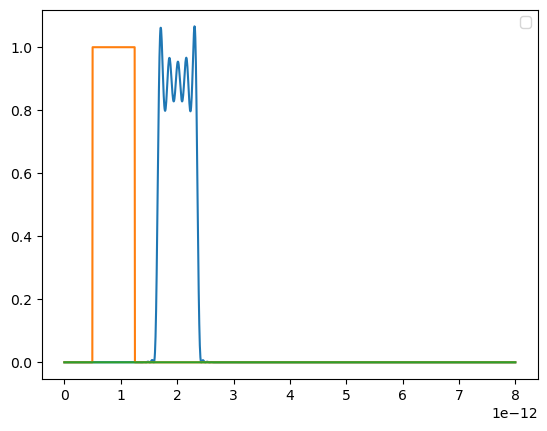

In [3]:
netlist = {
    "instances": {
        "wg": "waveguide",
    },
    "connections": {},
    "ports": {
        "o0": "wg,o0",
        "o1": "wg,o1",
    }
}
circuit, info = sax.circuit(
    netlist=netlist,
    models={
        "waveguide": ideal.waveguide,
    }
)

wvl_microns = np.linspace(1.51, 1.59, 200)
center_wvl = 1.55

ckt = circuit(wl=wvl_microns, wg={"length": 100, "loss": 50})
s_params = np.asarray(dict_to_matrix(ckt))
plt.plot(wvl_microns, np.abs(s_params[:, 0, 1])**2)
T = 1e-12

baseband_model  = BasebandModel(wvl_microns, center_wvl, s_params, 50)
response = baseband_model.compute_response(1, 0)
plt.plot(wvl_microns, np.abs(response)**2)
y = baseband_model.generate_sys_discrete()
#s_system = signal.dlti(y.A, y.B, y.C, y.D, dt = y.dt)
s_system = StateSpace(y.A, y.B, y.C, y.D, dt = y.dt)
# t = np.linspace(0.0, T, int(abs(T/y.dt)))
T = 8e-12
t = np.arange(0.0, T, y.dt)
u1 = np.zeros_like(t, dtype=complex)
u1[100:250] = 1
u2 = np.zeros_like(t, dtype=complex)
u = np.vstack([u1,u2]).T

input_signal = np.zeros((100, 2), dtype=complex)

input_signal[:, 1] = 0.0 + 0.0*1j
# t_out,y_out,x_out = dlsim_complex(s_system, u) 
t_out,y_out,x_out = dlsim_complex(s_system, u) 
plt.clf()
plt.plot(t_out, np.abs(y_out[:, 1])**2)
plt.plot(t_out, np.abs(u)**2)
# plt.step(t_out, u, where='post', label='Input: Rectangular Pulse', color='g', alpha=0.6)
# plt.step(t_out, y_out, where='post', label='Output response', color='b')
# plt.title('Baseband Model Output Response to Rectangular Pulse Input')
# plt.xlabel('Time')
# plt.ylabel('E-field Amp')

# T = 1e-12
# baseband_model.compute_state_space_model()
# sys = StateSpace(baseband_model.A, baseband_model.B, baseband_model.C, baseband_model.D, dt = 1* 1/baseband_model.sampling_freq)

# t = np.linspace(0.0, T, int(abs(T/sys.dt)))
# T = 1e-12
# u1 = np.zeros_like(t)
# u1[100:200] = 1
# u2 = np.zeros_like(t)
# u = np.vstack([u1,u2]).T

# input_signal = np.zeros((100, 2), dtype=complex)

# input_signal[:, 1] = 0.0 + 0.0*1j
# t_out,y_out,x_out = signal.dlsim(sys, u) 
# plt.step(t_out, u, where='post', label='Input: Rectangular Pulse', color='g', alpha=0.6)
# plt.step(t_out, y_out, where='post', label='Output response', color='b')
# plt.title('Baseband Model Output Response to Rectangular Pulse Input')
# plt.xlabel('Time')
# plt.ylabel('E-field Amp')


plt.legend()
plt.show()



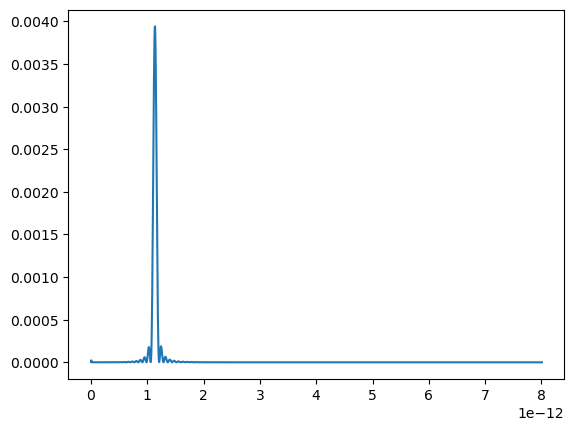

In [91]:
baseband_model.poles.shape
baseband_model.residues.shape

def compute_impulse_response(dpr_model, N = 1600):
    num_ports = dpr_model.num_ports
    response = np.zeros([N, num_ports, num_ports], dtype=complex)

    poles = dpr_model.poles

    for a in range(num_ports):
        for b in range(num_ports):
            residues = dpr_model.residues[:, a, b]
            dt = np.abs(1 / dpr_model.sampling_freq)
            t = np.linspace(0, dt*N, N)

            response[0, a, b] = dpr_model.D[a, b]
            for n in range(1, t.shape[0]):
                for p, r in zip(poles, residues):
                    response[n, a, b] += r*(p**(n-1))

    return t, response

t, impulse_response = compute_impulse_response(baseband_model)
plt.plot(t, np.abs(impulse_response[:, 0, 1])**2)
# plt.plot(t, np.angle(response))

In [109]:
from simphony.quantum import QuantumState, CoherentState, SqueezedState, compose_qstate


def to_unitary(s_params):
    """This method converts s-parameters into a unitary transform by adding
    vacuum ports.

    The original ports maintain their index while new vacuum ports will
    always be the last n_ports.

    Parameters
    ----------
    s_params : ArrayLike
        s-parameters in the shape of (n_freq, n_ports, n_ports).

    Returns
    -------
    unitary : Array
        The unitary s-parameters of the shape (n_freq, 2*n_ports,
        2*n_ports).
    """
    n_freqs, n_ports, _ = s_params.shape
    new_n_ports = n_ports * 2
    unitary = jnp.zeros((n_freqs, new_n_ports, new_n_ports), dtype=complex)
    for f in range(n_freqs):
        unitary = unitary.at[f, :n_ports, :n_ports].set(s_params[f])
        unitary = unitary.at[f, n_ports:, n_ports:].set(s_params[f])
        for i in range(n_ports):
            val = jnp.sqrt(
                1 - unitary[f, :n_ports, i].dot(unitary[f, :n_ports, i].conj())
            )
            unitary = unitary.at[f, n_ports + i, i].set(val)
            unitary = unitary.at[f, i, n_ports + i].set(-val)

    return unitary


def compute_unitary_matrices(impulse_response):
    unitary_matrices = np.zeros([impulse_response.shape[0], 2*impulse_response.shape[1], 2*impulse_response.shape[2]])

    # You can think of the transformation matrix as instaneous s-parameters
    for n in range(impulse_response.shape[0]):
        transformation_matrix = np.expand_dims(impulse_response[n], axis=0)
        unitary_matrices[n, :, :] = (to_unitary(transformation_matrix))
    
    return unitary_matrices
    


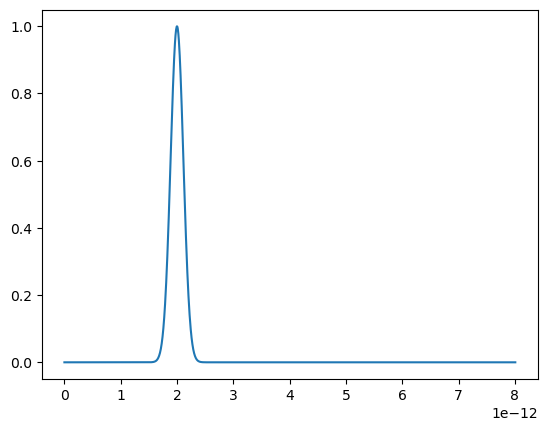

In [93]:
def quantum_input(amplitudes):
    states = []
    for amp in amplitudes:
        in_state = SqueezedState("o0", r=1.0, phi=0, alpha=amp/2 + 1j*amp/2)
        vac = CoherentState("o1", 0.0 + 0.0j)
        qstate = compose_qstate(in_state, vac)
        qstate._add_vacuums(2)
        qstate.to_xxpp()
        states.append(qstate)
    
    return states

amplitudes = gaussian_pulse(t, T/4, T/50)
plt.plot(t, amplitudes)
in_states = quantum_input(amplitudes)

In [111]:
quantum_unitaries = compute_unitary_matrices(impulse_response)
quantum_unitaries.shape

/tmp/ipykernel_4772/1824945911.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  unitary_matrices[n, :, :] = (to_unitary(transformation_matrix))


(1600, 4, 4)

In [106]:
len(quantum_unitaries)

1600

In [5]:
baseband_model.sampling_freq

-199786718647174.38

In [6]:
print(u.shape)
y.B.shape

(1599, 2)


(100, 2)

In [7]:
y_out[:, 1]


array([0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
       0.00000000e+00+0.00000000e+00j, ...,
       2.59786629e-08+7.24985445e-08j, 1.83476545e-08+1.17450440e-07j,
       1.04887689e-08+1.56862018e-07j])